### Data Prep/Feature Eng
* use cross val for tuning and selecting hyperparameters
* use test set at very end on best model
* find optimal complexityq to balance bias variance

### TRY ALL MODELS - but have rationale on why you are trying models
* document the iterative process

### Deliverables
* Contract by monday 2pm mountain time - communication frequency and tangible deadlines
* model completed by monday EOD
* proof of concept that your target and predictors are fit for machine learning classification
* decide as a team if target can be used as is or needs to be transformed
* FSM

### GROUP: Evan, Drew, Mustafa

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_var = pd.read_csv('data/training_set_features.csv')
df_tar = pd.read_csv('data/training_set_labels.csv')['seasonal_vaccine']

In [3]:
# Drop Based On Relevance
df_var = df_var.drop(['respondent_id','h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk',
                      'opinion_h1n1_sick_from_vacc','doctor_recc_h1n1','hhs_geo_region'],axis=1)

In [4]:
# Drop based on Nan
df_var = df_var.drop(['health_insurance','income_poverty','employment_industry','employment_occupation'],axis=1)

### Train Test Split

In [5]:
X_train,X_test,y_train,y_test = train_test_split(df_var,df_tar,random_state=42)
X_train = X_train.copy(deep=True)

In [6]:
# Imputing Majority Columns
imputer_majority = SimpleImputer(strategy='most_frequent')
majority_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance',
                     'behavioral_face_mask', 'behavioral_wash_hands',
                     'behavioral_large_gatherings', 'behavioral_outside_home',
                     'behavioral_touch_face', 'doctor_recc_seasonal',
                     'chronic_med_condition', 'child_under_6_months', 'health_worker',
                     'education', 'rent_or_own', 'marital_status', 'employment_status',
                     'sex'
                  ]

X_train[majority_columns] = imputer_majority.fit_transform(X_train[majority_columns])

In [7]:
# Imputing Opinion Columns
imputer_opinion = SimpleImputer(strategy='median')
opinion_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','household_adults', 'household_children'
                   ]

X_train[opinion_columns] = imputer_opinion.fit_transform(X_train[opinion_columns])

In [8]:
# One Hot Encoding
ohe = OneHotEncoder(drop='first',categories='auto')
ohe_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','age_group','education','race',
                   'employment_status', 'census_msa'
                   ]
ohe_array = ohe.fit_transform(X_train[ohe_columns])

ohe_df = pd.DataFrame(ohe_array.todense(),columns=ohe.get_feature_names(ohe_columns))
ohe_df.reset_index(inplace=True,drop=True)
X_train.reset_index(inplace=True,drop=True)

X_train_ohe = pd.concat([X_train.drop(ohe_columns,axis=1),ohe_df],axis=1,ignore_index=True)
X_train_ohe.columns = list(X_train.drop(ohe_columns,axis=1).columns) + list(ohe_df.columns)

In [9]:
# Ordinal Encoding
# Sex - 0=Female | 1=Male
# Marital Status - 0=Married | 1=Not Married
# Rent or Own - 0=Own | 1=Rent

oe = OrdinalEncoder(categories='auto')
X_train_ohe[['sex','marital_status','rent_or_own']] = oe.fit_transform(X_train[['sex','marital_status','rent_or_own']])

In [10]:
# Scaling Numerical Columns
ss = StandardScaler()
scaled_array = ss.fit_transform(X_train_ohe)
X_train_ohe_scaled = pd.DataFrame(scaled_array,columns=X_train_ohe.columns)

# Modeling

In [11]:
dt = DecisionTreeClassifier()

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,6,7,8,9,10],
    'min_samples_split': [30,35,40,45],
    'random_state': [0,10,20]
}

gs_dt = GridSearchCV(dt, param_grid_dt, cv=5)
gs_dt.fit(X_train_ohe_scaled, y_train)
gs_dt.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 35,
 'random_state': 0}

In [12]:
# Recursive Feature Elimination for Decision Tree
dt_cv_rfe = []
dt_keep_lists = []
max_features = 20
for n in range(1,max_features+1):
    num_features_to_select = n
    dt_rfe = DecisionTreeClassifier(criterion = 'gini',max_depth = 8,min_samples_split = 35,random_state = 0)
    select = RFE(dt_rfe, n_features_to_select=num_features_to_select)
    select.fit(X=X_train_ohe_scaled, y=y_train)
    feature_list = [(k,v) for k,v in zip(X_train_ohe_scaled.columns,select.support_)]
    current_keep_list = []
    for k,v in feature_list:
        if v:
            current_keep_list.append(k)
    
    current_cv = cross_val_score(dt_rfe,X_train_ohe_scaled[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

    dt_cv_rfe.append(current_cv)
    dt_keep_lists.append(current_keep_list)

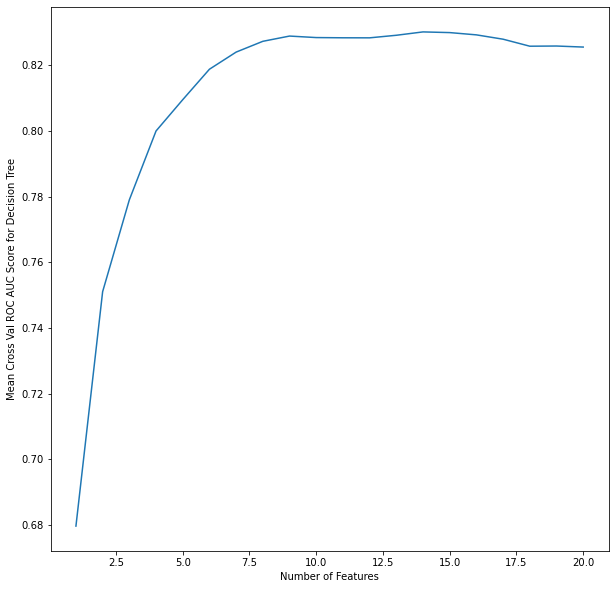

In [13]:
#Plotting Mean Cross Val AUC ROC for Decision Tree
# 13 is optimal value 
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range(1,max_features+1),dt_cv_rfe)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Mean Cross Val ROC AUC Score for Decision Tree')
plt.show()

In [15]:
# Final Decision Tree and Mean Cross Val AUC ROC Score
dt_final = DecisionTreeClassifier(criterion = 'gini',max_depth = 8,min_samples_split = 35,random_state = 0)
dt_final.fit(X_train_ohe_scaled[dt_keep_lists[13]],y_train)
cross_val_score(dt_final,X_train_ohe_scaled[dt_keep_lists[13]],y_train,cv=5,scoring='roc_auc').mean()

0.8320382192235016

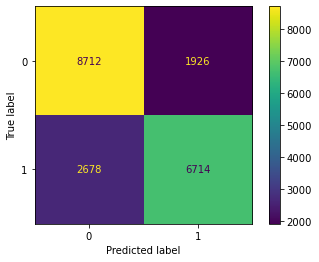

In [17]:
# Confusion Matrix of Final Decision Tree 
plot_confusion_matrix(dt_final,X_train_ohe_scaled[dt_keep_lists[13]],y_train)

# Random Forest

In [18]:
# Instantiate and fit a RandomForestClassifier
# n_estimators= 1000, criterion = 'gini', max_depth = 100, min_samples_split = 30, random_state = 0
# forest = RandomForestClassifier(n_estimators= 100, criterion = 'gini', max_depth = 1000, min_samples_split = 30,
#                                 random_state = 0)
RF = RandomForestClassifier()
param_grid_RF = {
      'n_estimators' : [10,100],
      'criterion' : ['gini', 'entropy'],
      'max_depth' : [50,100,500],
      'min_samples_split': [10,20,30],
      'random_state': [0,100,200]
}

gs_RF = GridSearchCV(RF, param_grid_RF, cv=5)
gs_RF.fit(X_train_ohe_scaled, y_train)
gs_RF.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_split': 30,
 'n_estimators': 100,
 'random_state': 100}

In [28]:
# Recursive Feature Elimination for Random Forest
RF_cv_rfe = []
RF_keep_lists = []
max_features = 30
for n in range(1,max_features+1):
    num_features_to_select = n
    RF_rfe = RandomForestClassifier(criterion = 'entropy', max_depth = 50, min_samples_split = 30, n_estimators= 100,
                                    random_state = 100)
    select = RFE(RF_rfe, n_features_to_select=num_features_to_select)
    select.fit(X=X_train_ohe_scaled, y=y_train)
    feature_list = [(k,v) for k,v in zip(X_train_ohe_scaled.columns,select.support_)]
    current_keep_list = []
    for k,v in feature_list:
        if v:
            current_keep_list.append(k)
    
    current_cv = cross_val_score(RF_rfe,X_train_ohe_scaled[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

    RF_cv_rfe.append(current_cv)
    RF_keep_lists.append(current_keep_list)

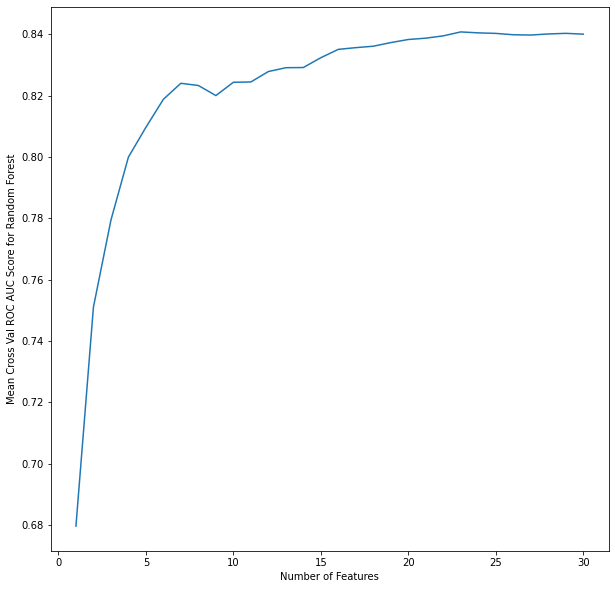

In [29]:
#Plotting Mean Cross Val AUC ROC for RFE Models
#  is optimal value 
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range(1,max_features+1),RF_cv_rfe)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Mean Cross Val ROC AUC Score for Random Forest')
plt.show()

In [33]:
RF_cv_rfe[22]

0.840740950433113

In [35]:
# Final Random Forest and Mean Cross Val AUC ROC Score
RF_final = RandomForestClassifier(criterion = 'entropy', max_depth = 50, min_samples_split = 30, n_estimators= 100,
                                    random_state = 100)
RF_final.fit(X_train_ohe_scaled[RF_keep_lists[22]],y_train)
cross_val_score(RF_final,X_train_ohe_scaled[RF_keep_lists[22]],y_train,cv=5,scoring='roc_auc').mean()

0.8407413330669602

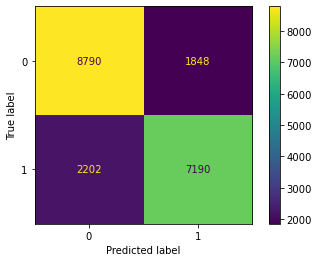

In [36]:
# Confusion Matrix of Final Random Forest
plot_confusion_matrix(RF_final,X_train_ohe_scaled[RF_keep_lists[22]],y_train)